In [77]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
import networkx as nx
from matplotlib import cm
from celluloid import Camera
import pickle #store

from scipy.sparse.csgraph import connected_components

In [78]:
n = 10 #nb des noeuds
k = 10  #nb des itérations
c = 1/(n+1)

a = 30 #longueur de l'espace
b = 20 #largeur de l'espace

r_det = ((a**2+b**2)**(1/2))/2  #rayon de détection
r_sec = r_det / 6

print(r_det)
print(r_sec)

18.027756377319946
3.0046260628866577


In [79]:
def positionToAdjMatrix(x,y,r_det):
    n=len(x)
    matrix = [[0 for i in range(n)] for j in range(n)]

    for i in range(n):
        for j in range(n):
            distance_ij = ((x[i]-x[j])**2 + (y[i]-y[j])**2)**(1/2)

            if distance_ij <= r_det :
                matrix[i][j] = 1

    # pas de boucle sur le même noeuds
    for i in range(n):
        matrix[i][i] = 0

    return matrix

def positionToGrpMatrix(x,y,r_sec):
    n=len(x)
    matrix = [[0 for i in range(n)] for j in range(n)]

    for i in range(n):
        for j in range(n):
            distance_ij = ((x[i]-x[j])**2 + (y[i]-y[j])**2)**(1/2)

            if distance_ij <= 2*r_sec :
                matrix[i][j] = 1

    # pas de boucle sur le même noeuds
    for i in range(n):
        matrix[i][i] = 0

    return matrix



def Laplacienne(M):
    #matrice degré
    D = np.identity(len(M[0]))
    degre = np.sum(M,axis=1)
    for i in range(n):
        D[i][i]=degre[i]
    
    #print("\n matrice degre\n",D)
    
    L = D - M
    
    return L

def adjToCom(M):
    #matrice de communication
    C = np.copy(np.array(M))
    facteur=np.sum(M,axis=1)
    C = C.astype('float')
    for i in range(n):
        if facteur[i]==0:
            facteur[i] = 1
        C[i]=C[i]/facteur[i]
    return C

def pMatrix(M):
    I = np.identity(len(M[0]))
    P = I - c*Laplacienne(M)
    
    return P

def randStocastic(n):
    matrix = np.random.rand(n,n)

    m = matrix/matrix.sum(axis=1)[:,None]
    
    return m


def matriceCom(H,W):
    
    I = np.identity(n)
    J = np.ones(n)
    Q = H + I
    Q_ = J - Q
    
    A = np.multiply(Q,W) + np.multiply(np.dot((np.multiply(W,Q_)),J),I)

    return A


def show_graph_with_labels(adjacency_matrix):
    rows, cols = np.where(adjacency_matrix == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=500, with_labels=True)
    plt.show()
    
def positionVirtuel(x,y,agent,voisin):
    
    return x,y
    
def mouvement(x,y,A):      
    for i in range(n):
        for j in range(n):
            x[i] += (x[j]-x[i])*A[i][j]
            y[i] += (y[j]-y[i])*A[i][j]      
    return x,y

def mouvementGrp(x,y,A,Grp):
    
    x_tmp,y_tmp = mouvement(x,y,A)
    
    nbGrp = connected_components(Grp)[0]
    groups = connected_components(Grp)[1]
    
    elementGrp=[0 for i in range(nbGrp)]
    for i in range(nbGrp):
        elementGrp[i] = np.where(groups==i)[0]
   
    for i in range(nbGrp):
        for j in elementGrp[i]:
            k=0
            x[j] +=  (x_tmp[elementGrp[i][k]]-x[elementGrp[i][k]])
            y[j] +=  (y_tmp[elementGrp[i][k]]-y[elementGrp[i][k]])
            k=k+1
    return x,y

def moyenne(elementGrp, x_tmp, y_tmp, x, y, mx,my ):
    
    for j in elementGrp:
            k = 0
            cardGrp = float(len(elementGrp))
            #print("\n\n x_tmp \n\n ",x_tmp)
            
            a = (x_tmp[elementGrp[k]]-x[elementGrp[k]])/cardGrp
            mx = mx + (x_tmp[elementGrp[k]]-x[elementGrp[k]])/cardGrp
            my = my + (y_tmp[elementGrp[k]]-y[elementGrp[k]])/cardGrp
            k += 1
            print("\n\n a \n\n ",a)
            
    return mx,my

def mouvementGrp2(x,y,A,Grp):
    
    x_tmp,y_tmp = mouvement(x,y,A)
    mx,my=0.,0.
    nbGrp = connected_components(Grp)[0]
    groups = connected_components(Grp)[1]
    

    elementGrp=[0 for i in range(nbGrp)]
    for i in range(nbGrp):
        elementGrp[i] = np.where(groups==i)[0]
   
    for i in range(nbGrp):
        for j in elementGrp[i]:
            
            x[j],y[j] = moyenne(elementGrp[i], x_tmp, y_tmp, x, y, mx, my)     
    return x,y

In [80]:
#positionner les robots aléatoirement 
rnd = np.random
rnd.seed(0)

#x = rnd.choice(np.arange(0., a, 5), size=n)
#y = rnd.choice(np.arange(0., b, 5), size=n)

x = [20., 25.,  0., 15., 30., 15.,  5., 15., 25., 10.]
y = [ 0., 15., 10.,  10.,  20.,  0., 10.,  5., 10., 15.]

M = positionToAdjMatrix(x,y,r_det)
print(x,y)

[20.0, 25.0, 0.0, 15.0, 30.0, 15.0, 5.0, 15.0, 25.0, 10.0] [0.0, 15.0, 10.0, 10.0, 20.0, 0.0, 10.0, 5.0, 10.0, 15.0]


matrice d'adjacence :
 [[0 1 0 1 0 1 1 1 1 1]
 [1 0 0 1 1 1 0 1 1 1]
 [0 0 0 1 0 1 1 1 0 1]
 [1 1 1 0 1 1 1 1 1 1]
 [0 1 0 1 0 0 0 0 1 0]
 [1 1 1 1 0 0 1 1 1 1]
 [1 0 1 1 0 1 0 1 0 1]
 [1 1 1 1 0 1 1 0 1 1]
 [1 1 0 1 1 1 0 1 0 1]
 [1 1 1 1 0 1 1 1 1 0]]


 matrice de groupement :
 [[0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


 group :
 [1 1 1 1 0 2 1 2 1 0]


 group :
 [0 7]


 connected graph :
 [0 1 2 0 3 0 2 0 1 4]


 connected graph list :
 [array([0, 3, 5, 7]), array([1, 8]), array([2, 6]), array([4]), array([9])]


 matrice de communication :
 [[0.         0.14285714 0.         0.14285714 0.         0.14285714
  0.14285714 0.14285714 0.14285714 0.14285714]
 [0.14285714 0.         0.         0.14285714 0.14285714 0.14285714
  0.         0.14285714 0.14285714 0.14285714]
 [0.         0.         0. 

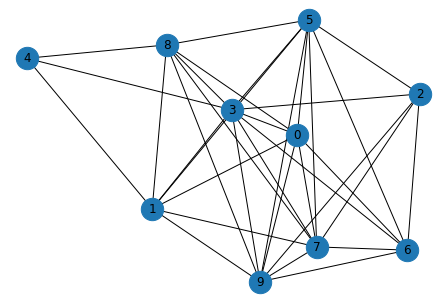

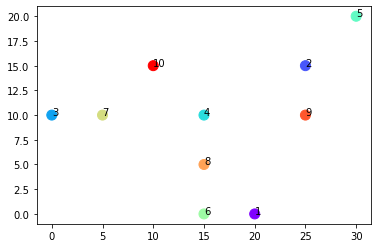

In [81]:
M = positionToAdjMatrix(x,y,r_det)

#affichage
a = np.array(M)
print("matrice d'adjacence :\n",a.reshape(n,n))

grp = np.array(positionToGrpMatrix(x,y,r_sec)).reshape(n,n)
print("\n\n matrice de groupement :\n",grp)

print("\n\n group :\n",np.sum(grp,axis=1))

itemindex = np.where(grp[5]==1)

print("\n\n group :\n",itemindex[0])

print("\n\n connected graph :\n",connected_components(grp)[1])

nbGrp = connected_components(grp)[0]
groups = connected_components(grp)[1]
    
elementGrp=[0 for i in range(nbGrp)]
for i in range(nbGrp):
    elementGrp[i] = np.where(groups==i)[0]

print("\n\n connected graph list :\n",elementGrp)    
        
#matrice de communication
C = adjToCom(M)
print("\n\n matrice de communication :\n", C.reshape(n,n))

print(C.sum(axis=0))

show_graph_with_labels(a)


colors = cm.rainbow(np.linspace(0, 1, n))
plt.scatter(x[0:], y[0:], c=colors, s=100)
    
for i in range(1,n+1):
    plt.annotate(i, (x[i-1], y[i-1]))

In [82]:
M = positionToAdjMatrix(x,y,r_det)
H = np.array(M).reshape(n,n)
print("\n matrice adjacence \n", H)

L = Laplacienne(M)
print("\n\n laplacienne \n", L)

P = pMatrix(H)
print("\n\n P \n",P)

valPropre = np.linalg.eigvals(L)
print("\n\n valeur propre de laplacienne",np.sort(valPropre, axis=0))

W = randStocastic(n)
print("\n\n matrice de priorité \n",W)


#matrice de communication
A = matriceCom(H,W)
print("\n\n matrice de communication :\n", A)




 matrice adjacence 
 [[0 1 0 1 0 1 1 1 1 1]
 [1 0 0 1 1 1 0 1 1 1]
 [0 0 0 1 0 1 1 1 0 1]
 [1 1 1 0 1 1 1 1 1 1]
 [0 1 0 1 0 0 0 0 1 0]
 [1 1 1 1 0 0 1 1 1 1]
 [1 0 1 1 0 1 0 1 0 1]
 [1 1 1 1 0 1 1 0 1 1]
 [1 1 0 1 1 1 0 1 0 1]
 [1 1 1 1 0 1 1 1 1 0]]


 laplacienne 
 [[ 7. -1.  0. -1.  0. -1. -1. -1. -1. -1.]
 [-1.  7.  0. -1. -1. -1.  0. -1. -1. -1.]
 [ 0.  0.  5. -1.  0. -1. -1. -1.  0. -1.]
 [-1. -1. -1.  9. -1. -1. -1. -1. -1. -1.]
 [ 0. -1.  0. -1.  3.  0.  0.  0. -1.  0.]
 [-1. -1. -1. -1.  0.  8. -1. -1. -1. -1.]
 [-1.  0. -1. -1.  0. -1.  6. -1.  0. -1.]
 [-1. -1. -1. -1.  0. -1. -1.  8. -1. -1.]
 [-1. -1.  0. -1. -1. -1.  0. -1.  7. -1.]
 [-1. -1. -1. -1.  0. -1. -1. -1. -1.  8.]]


 P 
 [[0.36363636 0.09090909 0.         0.09090909 0.         0.09090909
  0.09090909 0.09090909 0.09090909 0.09090909]
 [0.09090909 0.36363636 0.         0.09090909 0.09090909 0.09090909
  0.         0.09090909 0.09090909 0.09090909]
 [0.         0.         0.54545455 0.09090909 0.         0.090



 matrice de groupement :
 [[0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


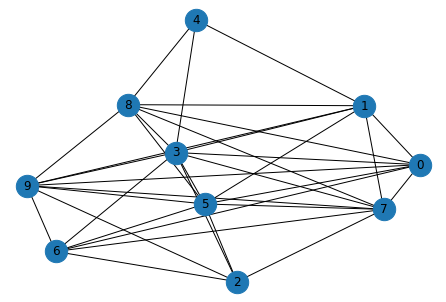

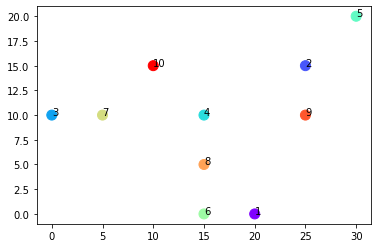



 matrice de groupement :
 [[0 0 0 1 0 1 0 1 1 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 1 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 1]
 [1 0 0 1 0 1 0 0 0 1]
 [1 1 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 1 1 0 0]]


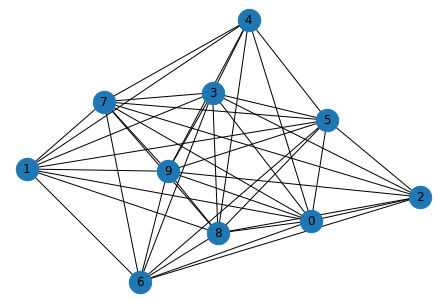

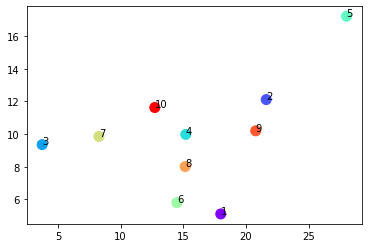



 matrice de groupement :
 [[0 1 0 1 0 1 1 1 1 1]
 [1 0 0 1 1 1 0 1 1 1]
 [0 0 0 0 0 1 1 0 0 1]
 [1 1 0 0 0 1 1 1 1 1]
 [0 1 0 0 0 0 0 0 0 0]
 [1 1 1 1 0 0 1 1 1 1]
 [1 0 1 1 0 1 0 1 1 1]
 [1 1 0 1 0 1 1 0 1 1]
 [1 1 0 1 0 1 1 1 0 1]
 [1 1 1 1 0 1 1 1 1 0]]


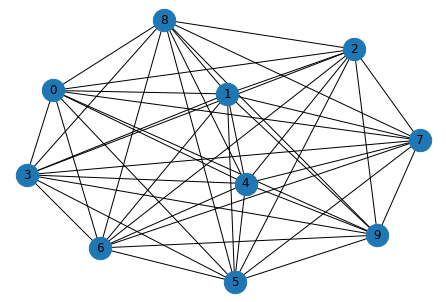

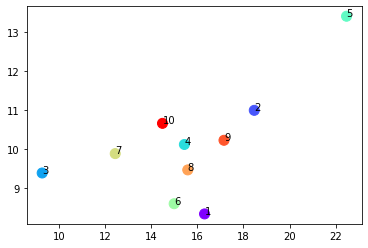



 matrice de groupement :
 [[0 1 1 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 0]]


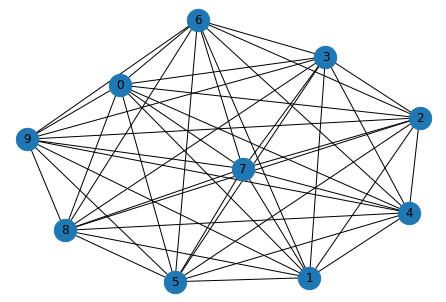

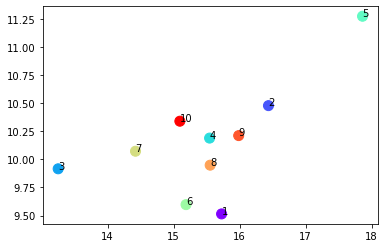



 matrice de groupement :
 [[0 1 1 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 0]]


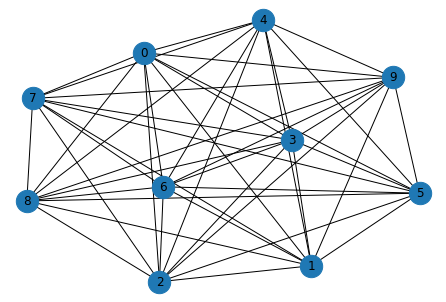

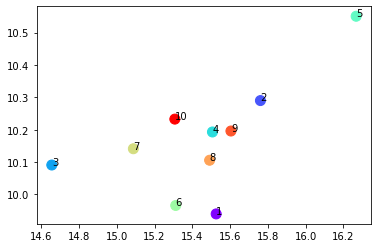



 matrice de groupement :
 [[0 1 1 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 0]]


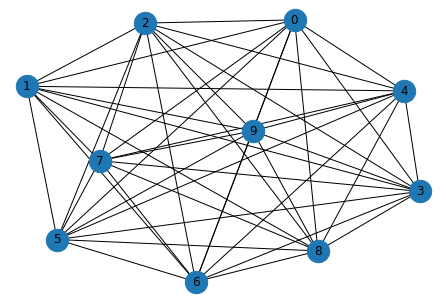

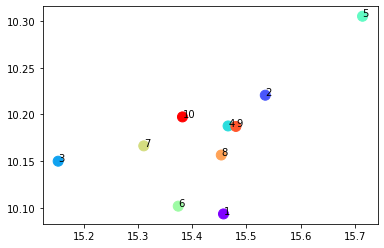



 matrice de groupement :
 [[0 1 1 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 0]]


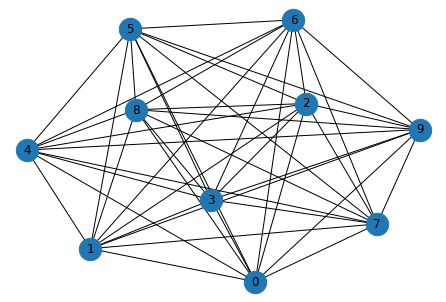

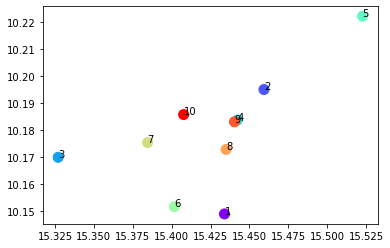



 matrice de groupement :
 [[0 1 1 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 0]]


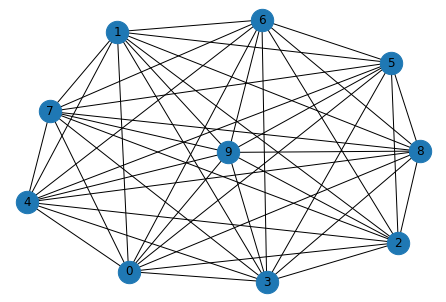

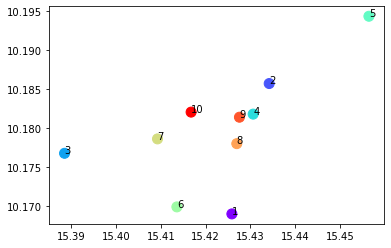



 matrice de groupement :
 [[0 1 1 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 0]]


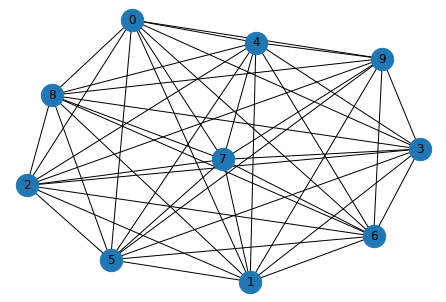

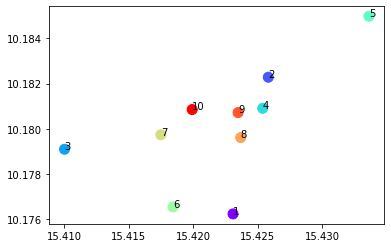



 matrice de groupement :
 [[0 1 1 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 0]]


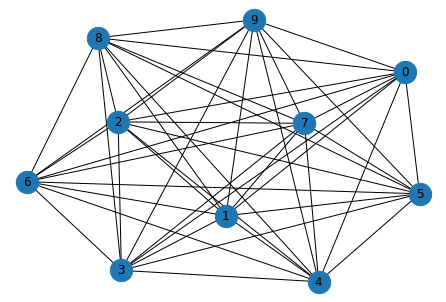

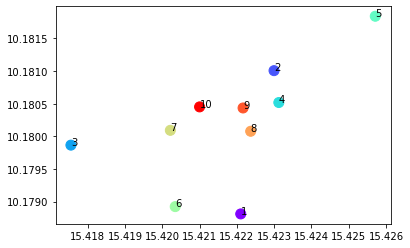

In [83]:
with open("initial.pkl",'wb') as f :
    pickle.dump([x,y],f)

camera = Camera(plt.figure())

#main

for _ in range(k):
    
    M = positionToAdjMatrix(x,y,r_det)
    H = np.array(M).reshape(n,n)
    P = pMatrix(H)
    W = np.dot(P,W)
    A = matriceCom(H,W)
    print("\n\n matrice de groupement :\n",np.array(positionToGrpMatrix(x,y,r_sec)).reshape(n,n))
    show_graph_with_labels(np.array(M))
    
    plt.scatter(x[0:], y[0:], c=colors, s=100)
    
    for i in range(1,n+1):
        plt.annotate(i, (x[i-1], y[i-1]))
        
    x,y = mouvement(x,y,A)
    
    plt.pause(1.1)
    camera.snap()

anim = camera.animate(blit=True)




 matrice de groupement :
 [[0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


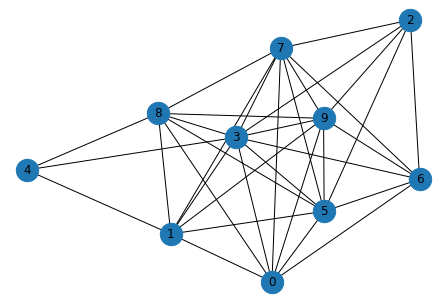

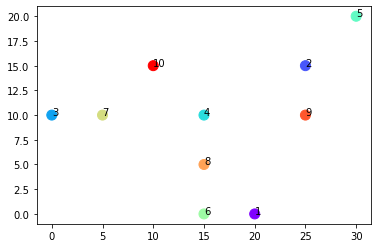



 matrice de groupement :
 [[0 0 0 1 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 0 0]
 [1 0 0 0 0 1 0 1 1 1]
 [0 0 0 0 0 0 0 0 0 0]
 [1 0 0 1 0 0 0 1 0 1]
 [0 0 1 0 0 0 0 0 0 1]
 [1 0 0 1 0 1 0 0 0 1]
 [0 1 0 1 0 0 0 0 0 0]
 [0 0 0 1 0 1 1 1 0 0]]


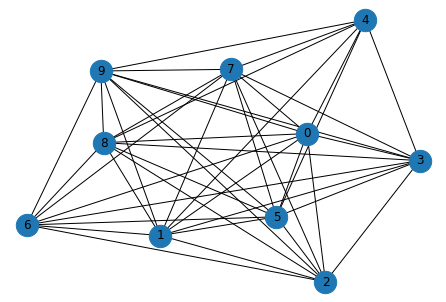

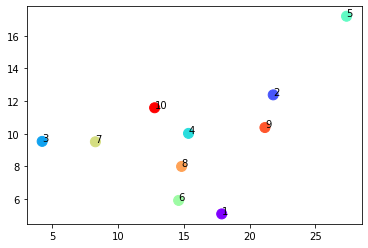



 matrice de groupement :
 [[0 1 1 1 0 1 1 1 1 1]
 [1 0 0 1 1 1 1 1 1 1]
 [1 0 0 1 0 1 1 1 0 1]
 [1 1 1 0 0 1 1 1 1 1]
 [0 1 0 0 0 0 0 0 1 0]
 [1 1 1 1 0 0 1 1 1 1]
 [1 1 1 1 0 1 0 1 1 1]
 [1 1 1 1 0 1 1 0 1 1]
 [1 1 0 1 1 1 1 1 0 1]
 [1 1 1 1 0 1 1 1 1 0]]


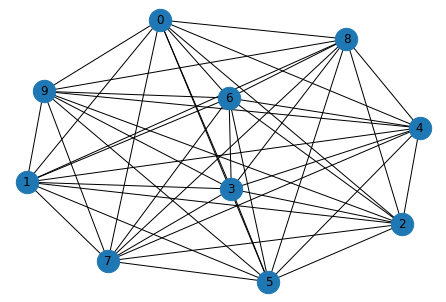

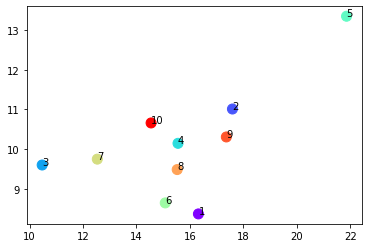



 matrice de groupement :
 [[0 1 1 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 0]]


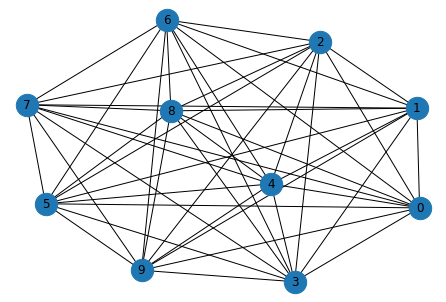

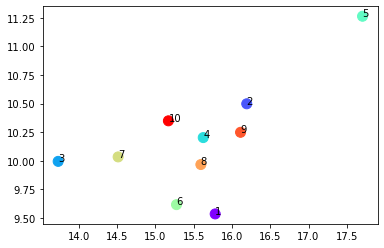



 matrice de groupement :
 [[0 1 1 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 0]]


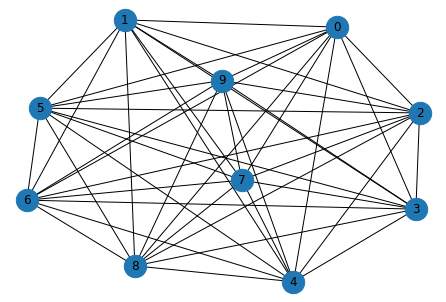

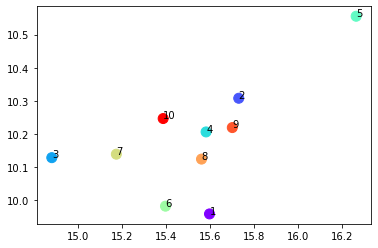



 matrice de groupement :
 [[0 1 1 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 0]]


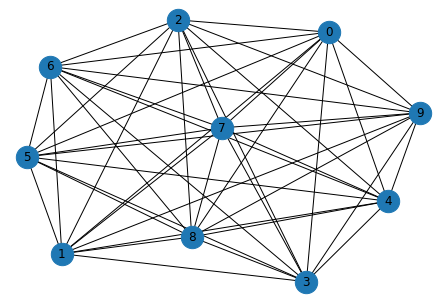

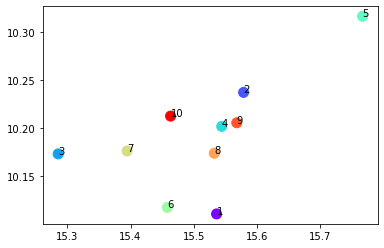



 matrice de groupement :
 [[0 1 1 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 0]]


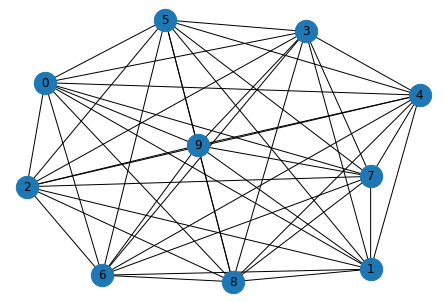

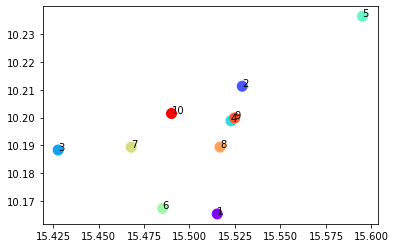



 matrice de groupement :
 [[0 1 1 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 0]]


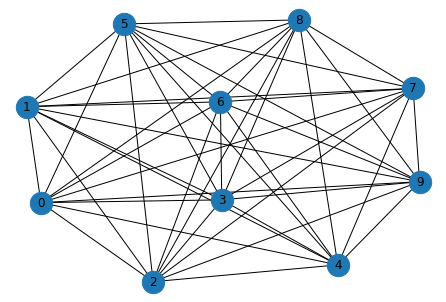

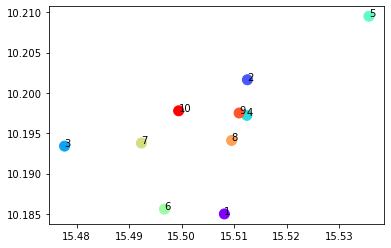



 matrice de groupement :
 [[0 1 1 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 0]]


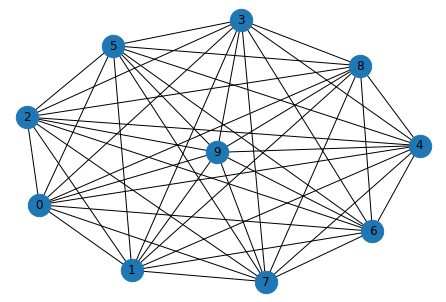

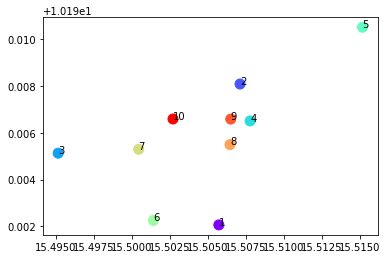



 matrice de groupement :
 [[0 1 1 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 0]]


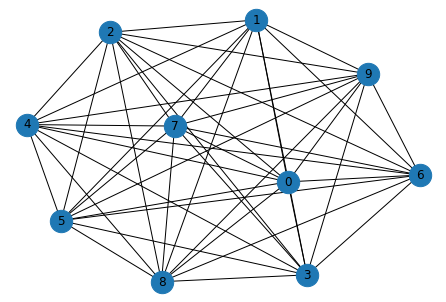

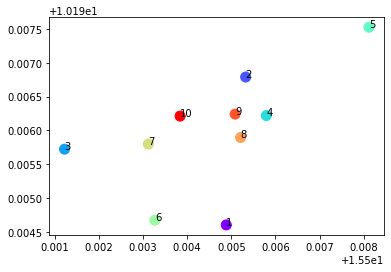

In [84]:
with open("initial.pkl",'rb') as f :
    x,y = pickle.load(f)

camera = Camera(plt.figure())

#main

for _ in range(k):
    
    M = positionToAdjMatrix(x,y,r_det)
    H = np.array(M).reshape(n,n)
    P = pMatrix(H)
    W = np.dot(P,W)
    A = matriceCom(H,W)
    
    Grp = np.array(positionToGrpMatrix(x,y,r_sec)).reshape(n,n)
    print("\n\n matrice de groupement :\n",Grp)
    show_graph_with_labels(np.array(M))
    
    plt.scatter(x[0:], y[0:], c=colors, s=100)
    
    for i in range(1,n+1):
        plt.annotate(i, (x[i-1], y[i-1]))
        
    x,y = mouvementGrp(x,y,A,Grp)
    
    plt.pause(1.1)
    camera.snap()

anim = camera.animate(blit=True)




 matrice de groupement :
 [[0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


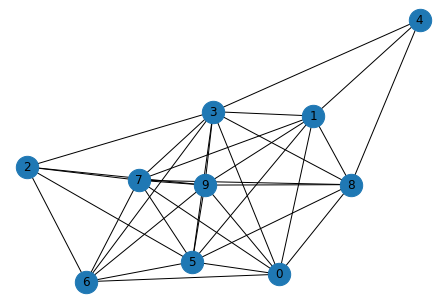



 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


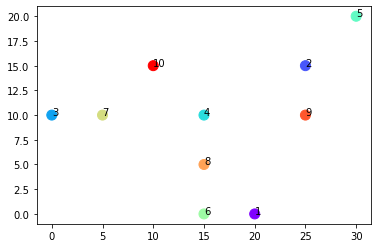



 matrice de groupement :
 [[0 1 1 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 0]]


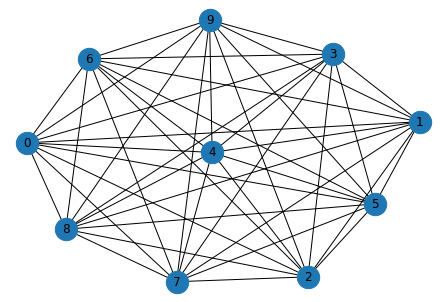



 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0

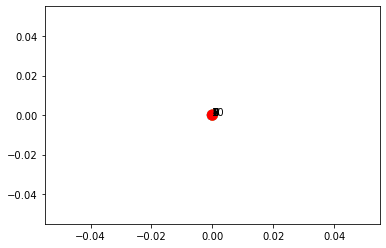



 matrice de groupement :
 [[0 1 1 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 0]]


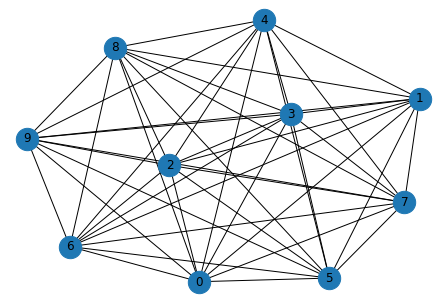



 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0

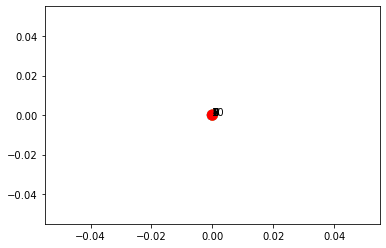



 matrice de groupement :
 [[0 1 1 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 0]]


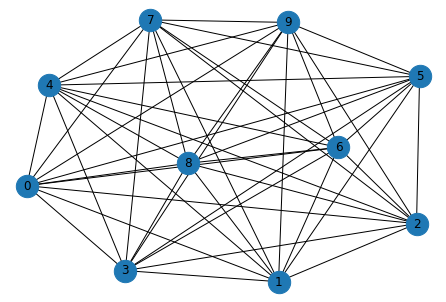



 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0

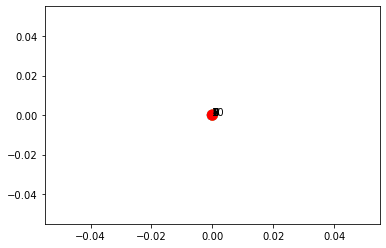



 matrice de groupement :
 [[0 1 1 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 0]]


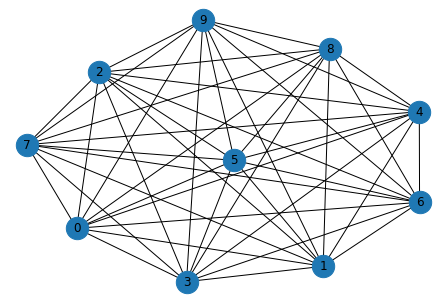



 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0

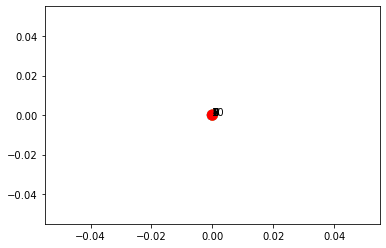



 matrice de groupement :
 [[0 1 1 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 0]]


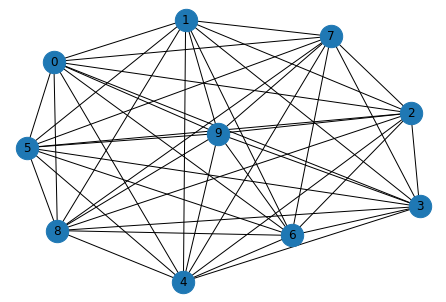



 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0

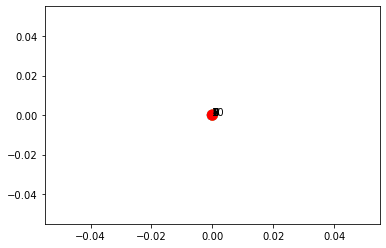



 matrice de groupement :
 [[0 1 1 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 0]]


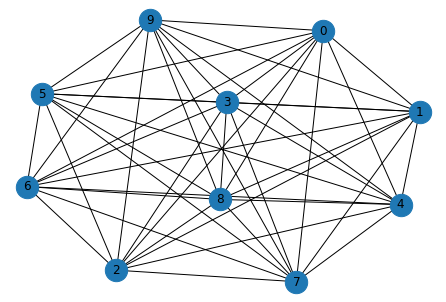



 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0

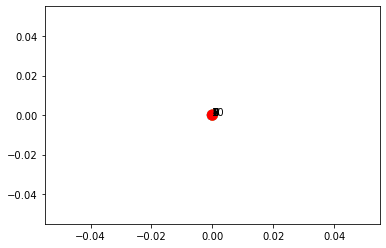



 matrice de groupement :
 [[0 1 1 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 0]]


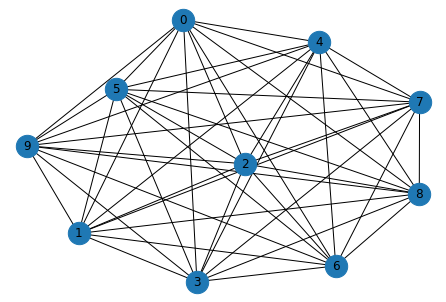



 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0

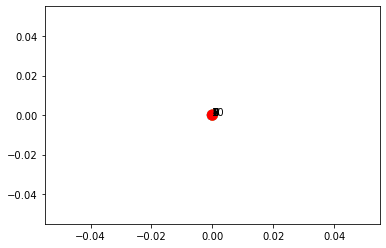



 matrice de groupement :
 [[0 1 1 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 0]]


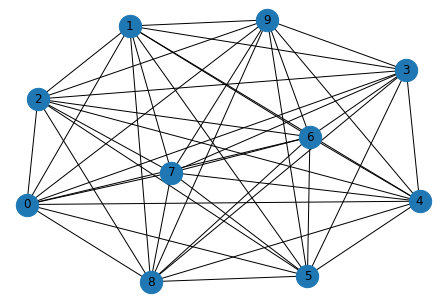



 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0

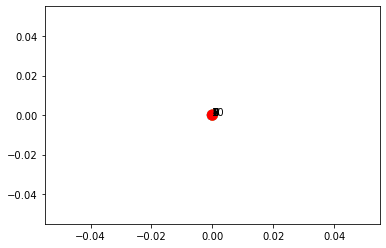



 matrice de groupement :
 [[0 1 1 1 1 1 1 1 1 1]
 [1 0 1 1 1 1 1 1 1 1]
 [1 1 0 1 1 1 1 1 1 1]
 [1 1 1 0 1 1 1 1 1 1]
 [1 1 1 1 0 1 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 1 0 1 1 1]
 [1 1 1 1 1 1 1 0 1 1]
 [1 1 1 1 1 1 1 1 0 1]
 [1 1 1 1 1 1 1 1 1 0]]


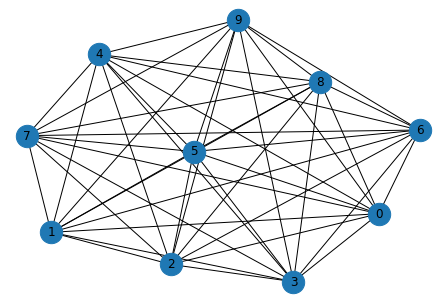



 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0


 a 

  0.0

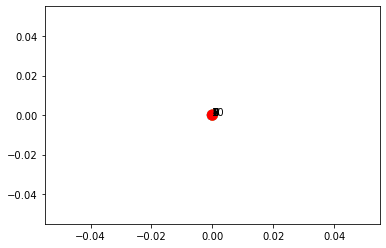

In [85]:
with open("initial.pkl",'rb') as f :
    x,y = pickle.load(f)

camera = Camera(plt.figure())

#main

for _ in range(k):
    
    M = positionToAdjMatrix(x,y,r_det)
    H = np.array(M).reshape(n,n)
    P = pMatrix(H)
    W = np.dot(P,W)
    A = matriceCom(H,W)
    
    Grp = np.array(positionToGrpMatrix(x,y,r_sec)).reshape(n,n)
    print("\n\n matrice de groupement :\n",Grp)
    show_graph_with_labels(np.array(M))
    
    plt.scatter(x[0:], y[0:], c=colors, s=100)
    
    for i in range(1,n+1):
        plt.annotate(i, (x[i-1], y[i-1]))
        
    x,y = mouvementGrp2(x,y,A,Grp)
    
    plt.pause(1.1)
    camera.snap()

anim = camera.animate(blit=True)